    "all_wheels_on_track": Boolean,        # flag to indicate if the agent is on the track
    "x": float,                            # agent's x-coordinate in meters
    "y": float,                            # agent's y-coordinate in meters
    "closest_objects": [int, int],         # zero-based indices of the two closest objects to the agent's current position of (x, y).
    "closest_waypoints": [int, int],       # indices of the two nearest waypoints.
    "distance_from_center": float,         # distance in meters from the track center 
    "is_crashed": Boolean,                 # Boolean flag to indicate whether the agent has crashed.
    "is_left_of_center": Boolean,          # Flag to indicate if the agent is on the left side to the track center or not. 
    "is_offtrack": Boolean,                # Boolean flag to indicate whether the agent has gone off track.
    "is_reversed": Boolean,                # flag to indicate if the agent is driving clockwise (True) or counter clockwise (False).
    "heading": float,                      # agent's yaw in degrees
    "objects_distance": [float, ],         # list of the objects' distances in meters between 0 and track_length in relation to the starting line.
    "objects_heading": [float, ],          # list of the objects' headings in degrees between -180 and 180.
    "objects_left_of_center": [Boolean, ], # list of Boolean flags indicating whether elements' objects are left of the center (True) or not (False).
    "objects_location": [(float, float),], # list of object locations [(x,y), ...].
    "objects_speed": [float, ],            # list of the objects' speeds in meters per second.
    "progress": float,                     # percentage of track completed
    "speed": float,                        # agent's speed in meters per second (m/s)
    "steering_angle": float,               # agent's steering angle in degrees
    "steps": int,                          # number steps completed
    "track_length": float,                 # track length in meters.
    "track_width": float,                  # width of the track
    "waypoints": [(float, float), ]        # list of (x,y) as milestones along the track center

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# 2022_may_open_ccw - Ross Raceway Counter-Clockwise

In [2]:
class Ref:
    history = {}


def reward_function(params):
    '''
    Reward for staying close to centre line. Centreline reward
    to have an s-shaped curve based on logistic function.

    Reward for making more progress per step, for example
    by cutting corners, as compared to its progress 10 steps ago,
    but don't reward if it goes off track. Reward per step increases
    in a non-linear upward curve, so that if the track is completed
    faster, and thus uses fewer steps, the reward is greater.

    The centre and progress are multiplied together.

    '''

    const_e = 2.718281828

    # Read input parameters
    track_width = params['track_width']
    distance_from_center = params['distance_from_center']
    progress = params['progress']  # percentage
    nsteps = int(params['steps'])  # 1/10 second
    track_length = params['track_length']  # metres
    all_wheels_on_track = params['all_wheels_on_track']
    speed = params['speed']  # metres per second

    # Setup history
    history = Ref.history
    if nsteps <= 1:
        history.clear()
    history[nsteps] = {
        'progress': progress,
        'all_wheels_on_track': all_wheels_on_track
    }

    # Overall scaling
    scaling_wt = 2.2

    # Raise progress to this exponent
    progress_power = 2

    # Logistic function parameters
    # https://en.wikipedia.org/wiki/Logistic_function
    # for following center
    k = 8  # steepness
    zone_width = 0.7  # normalized to track_width so 1.0 is at edge of track

    # logistic function for centerline
    x0 = zone_width * track_width / 2
    centreline_reward = 1 - 1 / (
        1 + const_e ** (k * (x0 - distance_from_center)))
    # never zero
    centreline_reward = max(0.001, centreline_reward)

    # progress in metres per step
    metres_per_step = 0.1 * speed  # default
    steps_in_history = [i for i in range(nsteps - 10, nsteps)
                        if i in history]
    if any(not history[i]['all_wheels_on_track'] for i in steps_in_history):
        # went off the track
        metres_per_step = 0.001
    else:
        for i in steps_in_history:
            metres_per_step = (
                progress - history[i]['progress']
            ) * track_length / 100 / (nsteps - i)
            break
    # never zero
    metres_per_step = max(0.001, metres_per_step)
    # approx reward = 1 at speed of 4 m/s
    progress_per_step_reward = 2.5 * metres_per_step

    # Non-linear so more progress is rewarded
    return scaling_wt * centreline_reward \
        * progress_per_step_reward ** progress_power


In [3]:
def plot_param(xmin, xmax, const_params, param_to_plot, reward_func):
    '''
    Plot output of the reward function by varying a single input parameter.
    
    xmin, xmax: range of input
    const_params: dict of values defining params to keep constant
    param_to_plot: name of parameter to plot
    reward_func: reward function matching standard deepracer signature
    '''
    x = list(np.linspace(xmin, xmax, num=40, dtype='O'))
    y = [
        reward_function({
            **const_params,
            param_to_plot: x_val
        })
        for x_val in x
    ]
    plt.figure()
    plt.plot(x, y, 'o')
    plt.grid()
    plt.show()

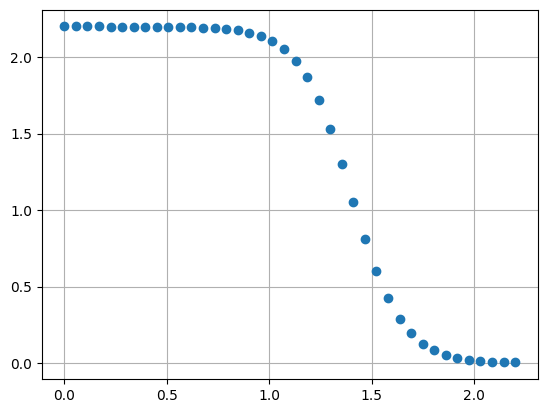

In [4]:
plot_param(
    0,
    2.2,
    const_params={'track_width': 4.0, 'progress': 50.0, 'steps': 250,
                  'track_length': 50, 'all_wheels_on_track': True,
                  'speed': 4.0},
    param_to_plot='distance_from_center',
    reward_func=reward_function
)

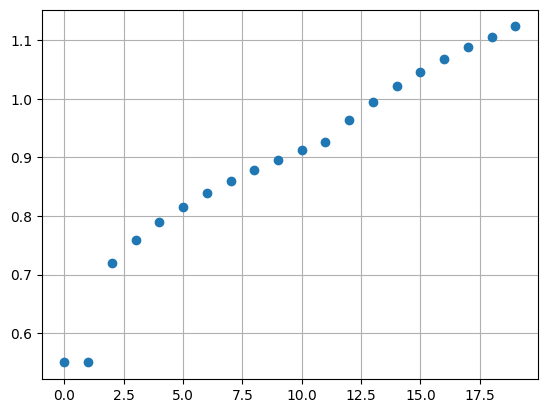

In [5]:
const_params={'track_width': 4.0, 'distance_from_center': 0.1,
              'track_length': 50, 'all_wheels_on_track': True,
              'speed': 2}
steps = list(range(20))
y = [
    reward_function({
        **const_params,
        'progress': s**1.1 * 0.2 * 100 / 50,
        'steps': s,
    })
    for s in steps
]
plt.figure()
plt.plot(steps, y, 'o')
plt.grid()
plt.show()

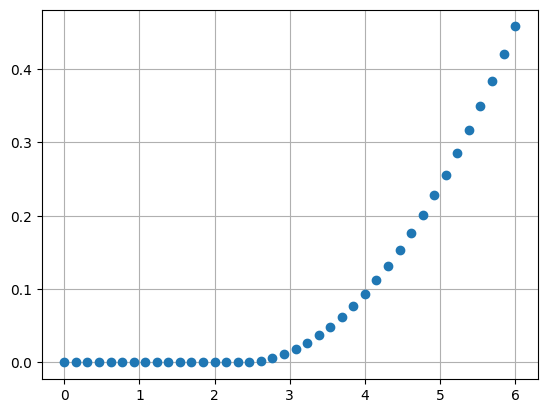

In [6]:
plot_param(
    0,
    6,
    const_params={'track_width': 4.0, 'distance_from_center': 0.1,
                  'track_length': 50, 'all_wheels_on_track': True,
                  'speed': 2.0, 'steps': 15},
    param_to_plot='progress',
    reward_func=reward_function
)

In [7]:
# make it go off track
for i in range(10, 12):
    reward_function({
        'track_width': 4.0, 'distance_from_center': 0.1,
        'track_length': 50, 'all_wheels_on_track': False,
        'speed': 2.0, 'steps': i, 'progress': 3
    })